# Let's build all kind of auto-de models.

In [1]:
#imports
import os
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from ioh_xplainer import explainer
import pandas as pd
import ioh
from scipy.stats import qmc
from ConfigSpace import ConfigurationSpace
from ConfigSpace.util import generate_grid
from IPython.display import display
from time import monotonic
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from matplotlib import pyplot as plt
import seaborn as sns

/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
ela_df = pd.read_pickle("ela-features-de.pkl")
features= ['F','CR', 'lambda_', 'mutation_base', 'mutation_reference',
       'mutation_n_comps', 'use_archive', 'crossover', 'adaptation_method',
       'lpsr']
ela_df.describe()

,CR,F,lambda_,mutation_n_comps,dim,fid,iid,auc,ela_meta.lin_simple.adj_r2,ela_meta.lin_simple.intercept,...,disp.diff_median_05,disp.diff_median_10,disp.diff_median_25,disp.costs_runtime,ic.h_max,ic.eps_s,ic.eps_max,ic.eps_ratio,ic.m0,ic.costs_runtime
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,...,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,0.603542,0.532292,18.316667,1.370833,17.500000,12.500000,3.000000,0.479656,0.412893,0.304977,...,-2.236977,-1.832161,-1.234911,0.076350,0.814460,-1.164248,0.008972,-1.969803,0.570708,32.903431
std,0.349354,0.411331,23.621841,0.484037,12.526123,6.936653,1.417169,0.366540,0.309993,0.212899,...,1.196892,0.982634,0.647996,0.055832,0.047360,0.394365,0.010255,0.460592,0.061463,31.872162
min,0.050000,0.250000,8.000000,1.000000,5.000000,1.000000,1.000000,0.000100,-0.012387,0.006332,...,-4.332638,-3.542501,-2.382481,0.035649,0.661395,-1.956957,0.000030,-4.139139,0.445892,0.868488
25%,0.250000,0.250000,10.000000,1.000000,5.000000,6.750000,2.000000,0.117947,0.074131,0.146591,...,-3.242814,-2.708075,-1.830551,0.040768,0.780949,-1.516517,0.003488,-2.142142,0.505762,1.648618
50%,0.750000,0.500000,14.000000,1.000000,17.500000,12.500000,3.000000,0.381266,0.436817,0.271535,...,-2.279125,-1.793952,-1.192525,0.054148,0.819140,-1.316316,0.005281,-2.017017,0.585170,19.190241
75%,1.000000,0.500000,14.000000,2.000000,30.000000,18.250000,4.000000,0.875078,0.666846,0.393664,...,-1.467562,-1.198076,-0.825482,0.077707,0.856744,-0.815816,0.011563,-1.656657,0.614479,65.535085
max,1.000000,1.750000,300.000000,2.000000,30.000000,24.000000,5.000000,0.998437,1.000000,0.972162,...,0.487208,0.316937,0.231666,0.349837,0.888130,-0.255255,0.066654,-0.995996,0.710421,78.704137


In [3]:
#load explainer
data_file = "de_final_processed.pkl" #read in modular DE data
df = pd.read_pickle(data_file)

config_dict = {}
for f in features:
    config_dict[f] = list(map(str, df[f].unique()))

config_dict['mutation_n_comps'] = [1,2]
config_dict['use_archive'] = [False, True]
config_dict['lpsr'] = [False, True]

#for each fid, iid get the best configuration  (mean?)
cs = ConfigurationSpace(config_dict)

print(cs)

de_explainer = explainer(None, 
                 cs , 
                 algname="mod-DE",
                 dims = [5,30],#, 10, 20, 40 
                 fids = np.arange(1,25), #,5
                 iids = df['iid'].unique(), #20 
                 reps = len( df['seed'].unique()), 
                 sampling_method = "grid",  #or random
                 grid_steps_dict = {},
                 sample_size = None,  #only used with random method
                 budget = 10000, #10000
                 seed = 1,
                 verbose = True)
de_explainer.load_results(data_file)
de_explainer.df.loc[de_explainer.df["dim"] == 30,'auc'] = de_explainer.df.loc[de_explainer.df["dim"] == 30,'aucLarge']

Configuration space object:
  Hyperparameters:
    CR, Type: Categorical, Choices: {0.05, 0.25, 0.5, 0.75, 1.0}, Default: 0.05
    F, Type: Categorical, Choices: {0.25, 0.5, 0.75, 1.25, 1.75}, Default: 0.25
    adaptation_method, Type: Categorical, Choices: {nan, jDE, shade}, Default: nan
    crossover, Type: Categorical, Choices: {exp, bin}, Default: exp
    lambda_, Type: Categorical, Choices: {8, 14, 10, 60, 50, 300}, Default: 8
    lpsr, Type: Categorical, Choices: {False, True}, Default: False
    mutation_base, Type: Categorical, Choices: {target, best, rand}, Default: target
    mutation_n_comps, Type: Categorical, Choices: {1, 2}, Default: 1
    mutation_reference, Type: Categorical, Choices: {pbest, rand, nan, best}, Default: pbest
    use_archive, Type: Categorical, Choices: {False, True}, Default: False



In [4]:
for f in features:
    print(f, ela_df[f].unique())

categorical_columns = features

df = ela_df.copy()
for cat in categorical_columns:
    print(cat)
    df[cat] = df[cat].astype('category')
    print(df[cat].unique())
    print(df[cat].cat.codes.unique())

ela_df_cat = ela_df.copy()
ela_df_cat[features] = ela_df_cat[features].apply(lambda col:pd.Categorical(col).codes)

F [0.25 0.75 0.5  1.75 1.25]
CR [0.5  0.75 0.25 0.05 1.  ]
lambda_ [  8  10  50  14  60 300]
mutation_base ['best' 'target' 'rand']
mutation_reference ['pbest' 'rand' 'nan' 'best']
mutation_n_comps [2 1]
use_archive [False  True]
crossover ['bin' 'exp']
adaptation_method ['shade' 'nan' 'jDE']
lpsr [False  True]
F
[0.25, 0.75, 0.50, 1.75, 1.25]
Categories (5, float64): [0.25, 0.50, 0.75, 1.25, 1.75]
[0 2 1 4 3]
CR
[0.50, 0.75, 0.25, 0.05, 1.00]
Categories (5, float64): [0.05, 0.25, 0.50, 0.75, 1.00]
[2 3 1 0 4]
lambda_
[8, 10, 50, 14, 60, 300]
Categories (6, int64): [8, 10, 14, 50, 60, 300]
[0 1 3 2 4 5]
mutation_base
['best', 'target', 'rand']
Categories (3, object): ['best', 'rand', 'target']
[0 2 1]
mutation_reference
['pbest', 'rand', 'nan', 'best']
Categories (4, object): ['best', 'nan', 'pbest', 'rand']
[2 3 1 0]
mutation_n_comps
[2, 1]
Categories (2, int64): [1, 2]
[1 0]
use_archive
[False, True]
Categories (2, bool): [False, True]
[0 1]
crossover
['bin', 'exp']
Categories (2, ob

In [5]:

#leave one function out 
def predToNames(y, dim):

    mapping = [[0.25, 0.5, 0.75, 1.25, 1.75], [0.05, 0.25, 0.5,  0.75, 1.], [ 8, 10, 14, 50, 60, 300],['best', 'rand', 'target'], ['best', 'nan', 'pbest', 'rand'], 
                [1, 2], [False, True], ['bin', 'exp'], ['jDE', 'nan', 'shade'], [False, True]]
    newy = {}
    i = 0
    for f in features:
        newy[f] = mapping[i][y[i]]
        i+=1
    #transform a numerical representation back to the categorical names
    return newy



#preprocess the data to train and test
fig, axes = plt.subplots(4, 12, sharey=True, figsize=(18,10))
fig.suptitle('AUCs of the Random Forest (RF), Decision Tree (DT), single best (SB) and average best configuration for Mod-DE on all functions using a leave-one function out validation.\n Dimensions 5 and 30 are separated during training of the models.')

dim_counter = 0
for dim in ela_df['dim'].unique():
    _, df_avg_best = de_explainer.get_average_best(dim)
    
    for fid in ela_df['fid'].unique():
        print(dim, fid)
        box_plot_df = pd.DataFrame(columns=['RF', 'DT','SB','AB', 'All'])

        _, df_single_best = de_explainer.get_single_best(fid, dim)
        box_plot_df['All'] = pd.Series(de_explainer.df[(de_explainer.df['fid'] == fid) & (de_explainer.df['dim'] == dim)]['auc'].values)
        box_plot_df['SB'] = pd.Series(df_single_best['auc'].values)
        box_plot_df['AB'] = pd.Series(df_avg_best[df_avg_best['fid'] == fid]['auc'].values)

        df = ela_df_cat[ela_df_cat['dim'] == dim]
        X_train = df[df['fid'] != fid].copy().drop(['fid','iid','auc',*features], axis=1)
        y_train = df[df['fid'] != fid][features]
        X_test = df[df['fid'] == fid].copy().drop(['fid','iid','auc',*features], axis=1)
        y_test = df[df['fid'] == fid][features]

        X_train.replace([np.inf, -np.inf], 0, inplace=True)
        X_test.replace([np.inf, -np.inf], 0, inplace=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)

        #y_train[features] = y_train[features].apply(lambda col:pd.Categorical(col).codes)
        #y_test[features] = y_test[features].apply(lambda col:pd.Categorical(col).codes)
    
        dtree = DecisionTreeClassifier(max_depth=7)
        dtree.fit(X_train, y_train)
        y_pred = dtree.predict(X_test)

        #RFx
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        y_red_rf = rf.predict(X_test)

        iid = 1
        all_aucs = []
        all_aucs_rf = []
        for y in y_pred:
            #print(y)
            conf = predToNames(y, dim)
            #print(conf)
            aucs = de_explainer.get_results_for_config(conf, dim, fid)
            all_aucs.extend(aucs.values)
            #print(all_aucs)
        for y in y_red_rf:
            #print(y)
            conf = predToNames(y, dim)
            #print(conf)
            aucs = de_explainer.get_results_for_config(conf, dim, fid)
            all_aucs_rf.extend(aucs.values)
            #print(all_aucs)

        box_plot_df['DT'] = pd.Series(np.array(all_aucs))
        box_plot_df['RF'] = pd.Series(np.array(all_aucs_rf))
        print(all_aucs)
        sns.violinplot(ax=axes[dim_counter + int((fid-1)/12)][(fid-1)%12], data=box_plot_df, showfliers = True, showmeans=True,
                    meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"6"})  
        # sns.boxplot(ax=axes[dim_counter + int((fid-1)/12)][(fid-1)%12], data=box_plot_df, showfliers = True, showmeans=True,
        #             meanprops={"marker":"o",
        #                "markerfacecolor":"white", 
        #                "markeredgecolor":"black",
        #               "markersize":"6"})  
        axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_title(f"$D={dim}$ $fid={fid}$")
        #axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_xticklabels(axes[dim_counter + int((fid-1)/12)][(fid-1)%12].get_xticks(), rotation=45)
    dim_counter += 2

plt.tight_layout()
plt.savefig("de_img_new/classifiers-fid.pdf")
plt.savefig("de_img_new/classifiers-fid.png")
plt.show()

plt.clf()
plt.close()

        

5 1
[0.583583928478427, 0.3392608543860411, 0.4374368607177481, 0.1909473176135164, 0.199720004057378, 0.1241959059098342, 0.1845975721200801, 0.4539084742994603, 0.1762229462157897, 0.1531556988826845, 0.3439391545715616, 0.1646738321993248, 0.3542499786848135, 0.2835477452315269, 0.1881078449706826, 0.9402504454819696, 0.9250104148544752, 0.9386015611814288, 0.9354688218839476, 0.9421949841989772, 0.9409480545333446, 0.1828444556944055, 0.9423492025051728, 0.9464553714171848, 0.9271443898607876, 0.9335877999782805, 0.9473536730808348, 0.9355158336750417, 0.9339563019937568, 0.9338046331882806, 0.583583928478427, 0.3392608543860411, 0.4374368607177481, 0.1909473176135164, 0.199720004057378, 0.1241959059098342, 0.1845975721200801, 0.4539084742994603, 0.1762229462157897, 0.1531556988826845, 0.3439391545715616, 0.1646738321993248, 0.3542499786848135, 0.2835477452315269, 0.1881078449706826, 0.583583928478427, 0.3392608543860411, 0.4374368607177481, 0.1909473176135164, 0.199720004057378, 0

5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
5 24
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24


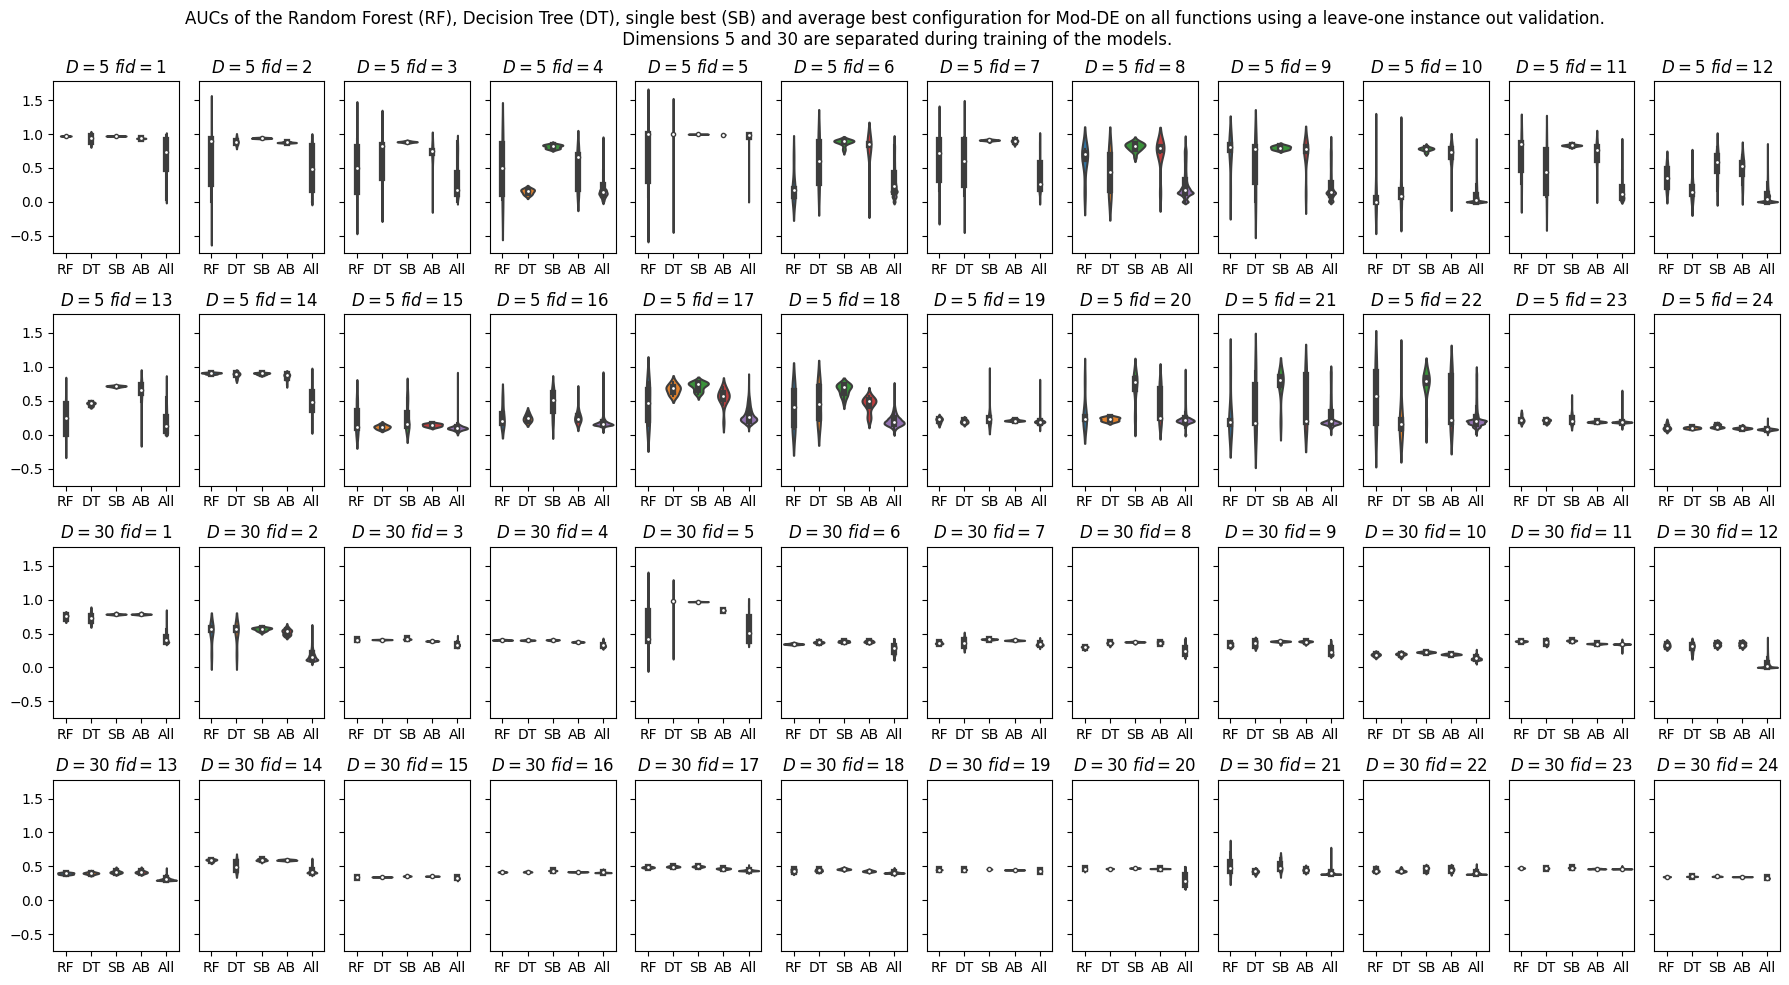

In [ ]:
#Leave one instance out
#preprocess the data to train and test
fig, axes = plt.subplots(4, 12, sharey=True, figsize=(18,10))
fig.suptitle('AUCs of the Random Forest (RF), Decision Tree (DT), single best (SB) and average best configuration for Mod-DE on all functions using a leave-one instance out validation.\n Dimensions 5 and 30 are separated during training of the models.')

dim_counter = 0
for dim in ela_df['dim'].unique():
    _, df_avg_best = de_explainer.get_average_best(dim)
    df = ela_df_cat[ela_df_cat['dim'] == dim].copy()
    
    for fid in ela_df['fid'].unique():
        print(dim, fid)
        box_plot_df = pd.DataFrame(columns=['RF', 'DT','SB','AB', 'All'])

        _, df_single_best = de_explainer.get_single_best(fid, dim)
        box_plot_df['All'] = pd.Series(de_explainer.df[(de_explainer.df['fid'] == fid) & (de_explainer.df['dim'] == dim)]['auc'].values)

        box_plot_df['SB'] = pd.Series(df_single_best['auc'].values)
        box_plot_df['AB'] = pd.Series(df_avg_best[df_avg_best['fid'] == fid]['auc'].values)

        all_aucs = []
        all_aucs_rf = []
        for iid in [1,5]:
            X_train = df[df['iid'] != iid].copy().drop(['fid','iid','auc',*features], axis=1)
            y_train = df[df['iid'] != iid][features]
            X_test = df[(df['iid'] == iid) & (df['fid'] == fid)].copy().drop(['fid','iid','auc',*features], axis=1)
            y_test = df[(df['iid'] == iid) & (df['fid'] == fid)][features]

            X_train.replace([np.inf, -np.inf], 0, inplace=True)
            X_test.replace([np.inf, -np.inf], 0, inplace=True)
            X_train.fillna(0, inplace=True)
            X_test.fillna(0, inplace=True)

            dtree = DecisionTreeClassifier(max_depth=7)
            dtree.fit(X_train, y_train)

            #RF
            rf = RandomForestClassifier()
            rf.fit(X_train, y_train)

            #DT
            y_pred = dtree.predict(X_test)

            #RF
            y_red_rf = rf.predict(X_test)

        
            for y in y_pred:
                #print(y)
                conf = predToNames(y, dim)
                #print(conf)
                aucs = de_explainer.get_results_for_config(conf, dim, fid, iid)
                all_aucs.extend(aucs.values)
                #print(all_aucs)
            for y in y_red_rf:
                #print(y)
                conf = predToNames(y, dim)
                #print(conf)
                aucs = de_explainer.get_results_for_config(conf, dim, fid, iid)
                all_aucs_rf.extend(aucs.values)
                #print(all_aucs)

        box_plot_df['DT'] = pd.Series(np.array(all_aucs))
        box_plot_df['RF'] = pd.Series(np.array(all_aucs_rf))
        sns.violinplot(ax=axes[dim_counter + int((fid-1)/12)][(fid-1)%12], data=box_plot_df, showfliers = True, showmeans=True,
                    meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"6"})
        axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_title(f"$D={dim}$ $fid={fid}$")
        #axes[dim_counter + int((fid-1)/12)][(fid-1)%12].set_xticklabels(axes[dim_counter + int((fid-1)/12)][(fid-1)%12].get_xticks(), rotation=45)
    dim_counter += 2

plt.tight_layout()
plt.savefig("de_img_new/classifiers-iid.pdf")
plt.savefig("de_img_new/classifiers-iid.png")
plt.show()

plt.clf()
plt.close()

In [ ]:
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

#plot decision tree
import dtreeviz

mapping = [[0.25, 0.5, 0.75, 1.25, 1.75], [0.05, 0.25, 0.5,  0.75, 1.], [ 8, 10, 14, 50, 60, 300],['best', 'rand', 'target'], ['best', 'nan', 'pbest', 'rand'], 
            [1, 2], [False, True], ['bin', 'exp'], ['jDE', 'nan', 'shade'], [False, True]]

for dim in [5,30]:
    df = ela_df_cat[ela_df_cat['dim'] == dim].copy()

    X_train = df.copy().drop(['fid','iid','auc',*features], axis=1)
    y_train = df[features]

    X_train.replace([np.inf, -np.inf], 0, inplace=True)
    X_train.fillna(0, inplace=True)
    fi = 0
    for f in features:
        
        old_values = y_train[f].unique()
        new_values = np.arange(0,len(y_train[f].unique()))

        y = y_train.copy()
        for n in new_values:
            y.loc[y_train[f] == old_values[n], f] = n #update 4 to 3
        labels = list(np.array(mapping[fi])[old_values])
        #print(old_values, new_values, labels)

        dtree = DecisionTreeClassifier(max_depth=7)
        dtree.fit(X_train, y[f])
        print(f"d{dim} f{f} score", dtree.score(X_train, y[f]))

        viz_model = dtreeviz.model(dtree, X_train, y[f],
            target_name=f,
            feature_names=X_train.columns,
            class_names=labels 
        )
        v = viz_model.view(scale=1.0)
        v.save(f"trees_de/d{dim}-f{f}.svg")
        fi += 1
    
    #fig = plt.figure(figsize=(25,20))
    #_ = tree.plot_tree(dtree, 
    #                feature_names=X_train.columns,  
    #                class_names=features,
    #                filled=True)
    #plt.show()

d5 fF score 0.9666666666666667


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fCR score 0.9333333333333333


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 flambda_ score 1.0


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fmutation_base score 0.8333333333333334


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fmutation_reference score 0.8


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fmutation_n_comps score 0.9666666666666667


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fuse_archive score 0.9916666666666667


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fcrossover score 0.9833333333333333


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 fadaptation_method score 0.975


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d5 flpsr score 0.9833333333333333


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fF score 0.9666666666666667


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fCR score 0.9333333333333333


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 flambda_ score 1.0


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fmutation_base score 0.8833333333333333


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fmutation_reference score 0.7583333333333333


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fmutation_n_comps score 0.95


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fuse_archive score 0.9916666666666667


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fcrossover score 1.0


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 fadaptation_method score 0.9083333333333333


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


d30 flpsr score 1.0


/home/neocortex/repos/ioh-explainer/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
